In [1]:
import pandas as pd
import torch.nn as nn
from tbnn.training_utils import early_stopped_tbnnPlus_training_run
import torch
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import tbnn.models as models
import tbnn.devices as devices
import tbnn.dataloaders as dataloaders
import tbnn.losses as losses
device = devices.get_device()



In [2]:
dataset_params = {'file': '/home/ryley/WDK/ML/dataset/komegasst_split.csv',
                  'test_set': ['fp_3630'],
                }

df = pd.read_csv(dataset_params['file'])

df = df[df['Case'].isin(['fp_3630', 'fp_3970','fp_4060'])]

df_test = df[df['Case'].isin(dataset_params['test_set'])]
df_tv = df[~df['Case'].isin(dataset_params['test_set'])]
print(f'Dataset: {len(df)}, test: {len(df_test)}, tv: {len(df_tv)}')



Dataset: 511, test: 168, tv: 343


Training points: 171, validation points 172
EPOCH    LR        TRAIN     VALID         MSE_b:T/V         MSE_g1:T/V            RL:T/V         %NR_t/%NR_v
  1   1.000e-03   0.05154   0.05129   0.03236 / 0.03223   1.91792 / 1.90594   0.00000 / 0.00000   0.00% / 0.00%
 10   9.955e-04   0.03865   0.03850   0.03118 / 0.03107   0.74619 / 0.74096   0.00000 / 0.00000   1.75% / 1.74%
 20   9.905e-04   0.03177   0.03169   0.02451 / 0.02449   0.72545 / 0.72012   0.00000 / 0.00000   0.00% / 0.00%
 30   9.856e-04   0.01847   0.01847   0.01191 / 0.01197   0.65539 / 0.65053   0.00000 / 0.00000   0.00% / 0.00%
 40   9.807e-04   0.01597   0.01595   0.00956 / 0.00959   0.64154 / 0.63686   0.00000 / 0.00000   1.75% / 0.00%
 50   9.758e-04   0.01497   0.01499   0.00912 / 0.00917   0.58563 / 0.58132   0.00000 / 0.00000   1.17% / 0.00%
 60   9.709e-04   0.01443   0.01444   0.00848 / 0.00854   0.59459 / 0.59018   0.00000 / 0.00000   2.34% / 0.00%
 70   9.661e-04   0.01584   0.01584   0.00772 / 0.00779   0.81

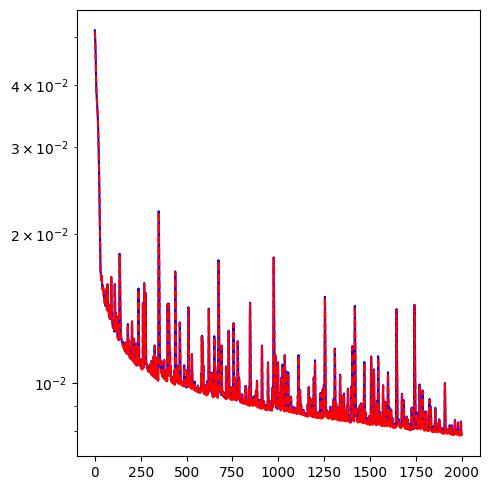

In [3]:
training_params = {'early_stopping_patience': 500,
                    'max_epochs': 2000,
                      'learning_rate': 0.001,
                        'learning_rate_decay': 0.9995,
                          'batch_size': 32,
                            'val_set': ['fp_4060']}

model_params = {'neurons': 20, 'n_hidden': 3, 'activation_function': nn.SiLU(),                 
                #'input_features': ['komegasst_q6','komegasst_q5','komegasst_I1_1','komegasst_I1_3','komegasst_I2_3','komegasst_I1_5']
                'input_features':['komegasst_I1_1',
'komegasst_I1_3',
'komegasst_I1_4',
'komegasst_I1_5',
#'komegasst_I1_16',
#'komegasst_I1_7',
#'komegasst_I1_9',
#'komegasst_I1_10',
#'komegasst_I1_12',
#'komegasst_I1_13',
#'komegasst_I1_16',
'komegasst_q5',
#'komegasst_q6',
]
}

model = models.TBNNPlus(N = 10,
                input_dim = len(model_params['input_features']),
                n_hidden = model_params['n_hidden'],
                neurons = model_params['neurons'],
                activation_function = model_params['activation_function'],
                input_feature_names=model_params['input_features']
            ).to(device)

model, loss_vals, val_loss_vals  = early_stopped_tbnnPlus_training_run(model = model,
                                                                   training_params = training_params,
                                                                   df_tv = df_tv)

fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(loss_vals,'-',color='b')
ax.plot(val_loss_vals,'--',color='r')
ax.semilogy()
fig.tight_layout()
#fig.savefig(f'models/model_cluster_{cluster}.png',dpi=300)

In [10]:
import tbnn.training_utils as training_utils
import numpy as np
from torch.utils.data import Dataset, DataLoader

df_train = df[~df['Case'].isin(dataset_params['test_set']+training_params['val_set'])]
#df_test = df[df['Case'].isin(test_set)].copy()


df_test[f'pred_b_11_all'] = np.zeros(len(df_test))
df_test[f'pred_b_12_all'] = np.zeros(len(df_test))
df_test[f'pred_b_13_all'] = np.zeros(len(df_test))
df_test[f'pred_b_22_all'] = np.zeros(len(df_test))
df_test[f'pred_b_23_all'] = np.zeros(len(df_test))
df_test[f'pred_b_33_all'] = np.zeros(len(df_test))


#model_params = pickle.load(open(f"models/params_cluster_all.pickle", "rb"))
#df_train_i = df_train[df_train['Cluster'] == cluster]
#df_test_i = df_test[df_test['Cluster'] == cluster].copy()

tDs = dataloaders.bDatasetPlus(df_train, input_features=model_params['input_features'])
testDs = dataloaders.bDatasetPlus(df_test, input_features=model_params['input_features'],scaler_X = tDs.scaler_X)

model.eval()
for X, T, y, g1tilde in DataLoader(testDs, shuffle=False, batch_size=testDs.__len__()):
    y_pred_test, gn = model(X,T)
    #print(f"loss: {losses.bLoss(y_pred_test,y)}")
    #print(f"loss: {losses.mseLoss(y_pred_test,y)}")
    #print(f"loss: {losses.realizabilityPenalty(y)}")
    #print(f"loss: {losses.realizabilityPenalty_components(y)}")
    #print(f"loss: {losses.realizabilityPenalty_eigs(y)}")


    #val_loss_values.append(loss_fn(y_pred_val,y).item())   
    #mse_v = mseLoss(y_pred_val,y).item()  
    #rl_v = realizLoss(y_pred_val,y).item()
#for prediction_name in ['pred_b_11','pred_b_12','pred_b_13','pred_b_22','pred_b_23','pred_b_33']:
#print(y_pred_test.shape)
df_test[f'pred_b_11_all'] = y_pred_test[:,0,0].detach().numpy()
df_test[f'pred_b_12_all'] = y_pred_test.detach().numpy()[:,0,1]
df_test[f'pred_b_13_all'] = y_pred_test.detach().numpy()[:,0,2]
df_test[f'pred_b_22_all'] = y_pred_test.detach().numpy()[:,1,1]
df_test[f'pred_b_23_all'] = y_pred_test.detach().numpy()[:,1,2]
df_test[f'pred_b_33_all'] = y_pred_test.detach().numpy()[:,2,2]

df_test[f'pred_g1'] = gn[:,0].detach().numpy()
df_test[f'pred_g2'] = gn[:,1].detach().numpy()
df_test[f'pred_g3'] = gn[:,2].detach().numpy()
df_test[f'pred_g4'] = gn[:,3].detach().numpy()
df_test[f'pred_g5'] = gn[:,4].detach().numpy()
df_test[f'pred_g6'] = gn[:,5].detach().numpy()
df_test[f'pred_g7'] = gn[:,6].detach().numpy()
df_test[f'pred_g8'] = gn[:,7].detach().numpy()
df_test[f'pred_g9'] = gn[:,8].detach().numpy()
df_test[f'pred_g10'] = gn[:,9].detach().numpy()
df_test[f'labels_scaled_g1tilde'] = g1tilde #tDs.scaler_g1tilde.inverse_transform(g1tilde.detach().numpy().reshape(-1, 1))
df_test[f'pred_g1tilde'] = np.log(-gn[:,0].detach().numpy())#tDs.scaler_g1tilde.inverse_transform(np.exp(-gn[:,0].detach().numpy()).reshape(-1, 1))




/tmp/ipykernel_14008/208228390.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'pred_b_11_all'] = np.zeros(len(df_test))
/tmp/ipykernel_14008/208228390.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'pred_b_12_all'] = np.zeros(len(df_test))
/tmp/ipykernel_14008/208228390.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

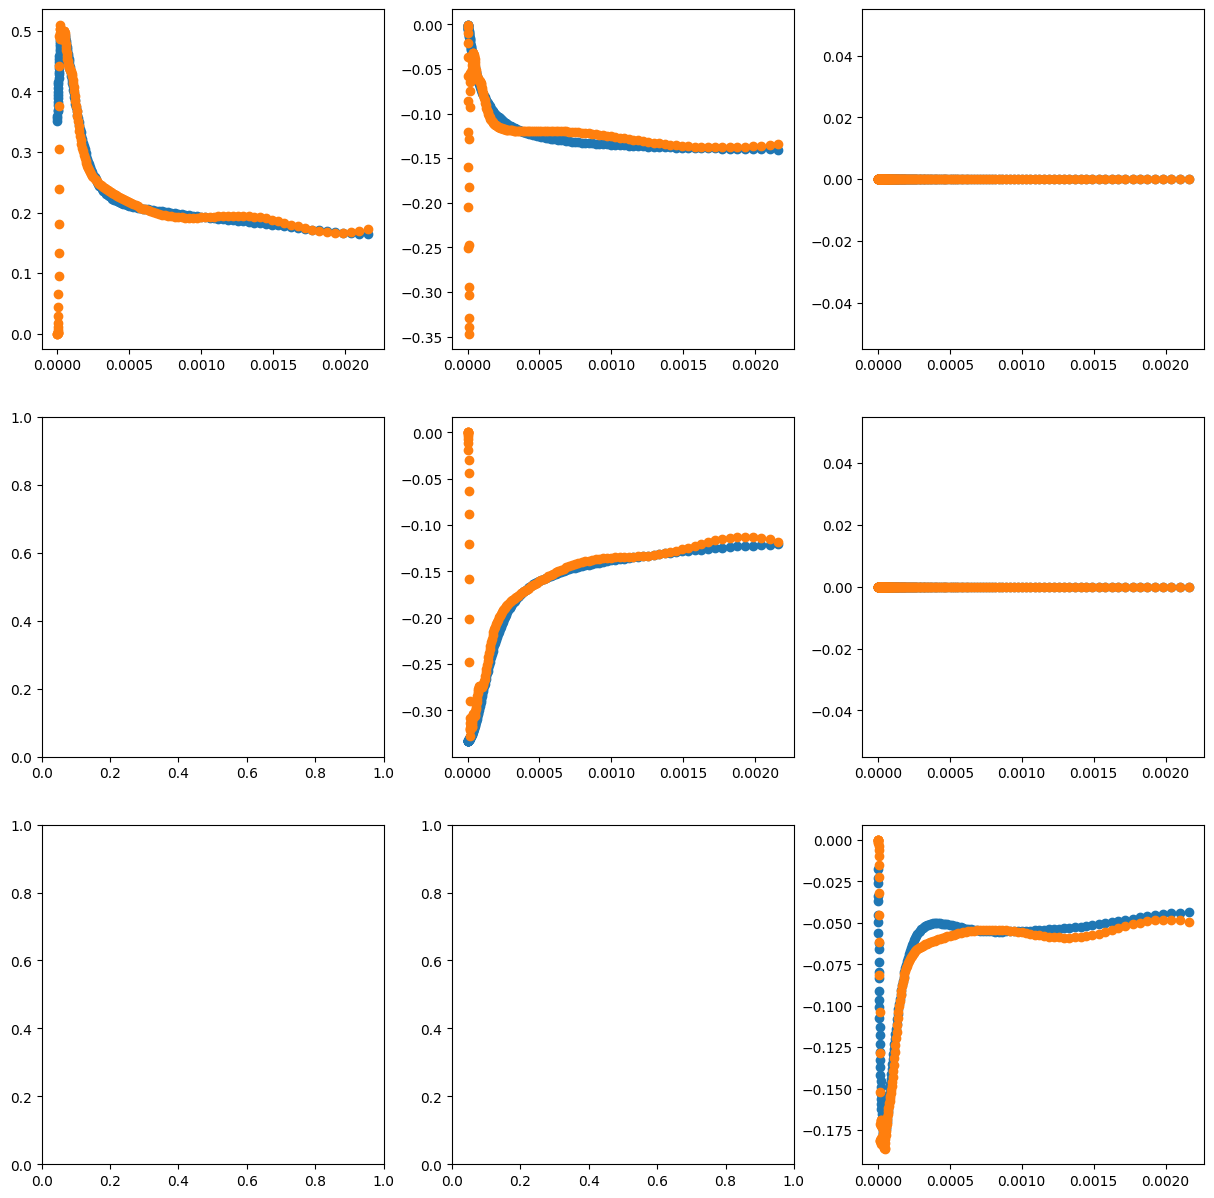

In [11]:
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(15,15))
axs[0,0].scatter(df_test['komegasst_C_2'],df_test['DNS_b_11'])
axs[0,0].scatter(df_test['komegasst_C_2'],df_test['pred_b_11_all'])

axs[0,1].scatter(df_test['komegasst_C_2'],df_test['DNS_b_12'])
axs[0,1].scatter(df_test['komegasst_C_2'],df_test['pred_b_12_all'])

axs[0,2].scatter(df_test['komegasst_C_2'],df_test['DNS_b_13'])
axs[0,2].scatter(df_test['komegasst_C_2'],df_test['pred_b_13_all'])

axs[1,1].scatter(df_test['komegasst_C_2'],df_test['DNS_b_22'])
axs[1,1].scatter(df_test['komegasst_C_2'],df_test['pred_b_22_all'])

axs[1,2].scatter(df_test['komegasst_C_2'],df_test['DNS_b_23'])
axs[1,2].scatter(df_test['komegasst_C_2'],df_test['pred_b_23_all'])

axs[2,2].scatter(df_test['komegasst_C_2'],df_test['DNS_b_33'])
axs[2,2].scatter(df_test['komegasst_C_2'],df_test['pred_b_33_all'])

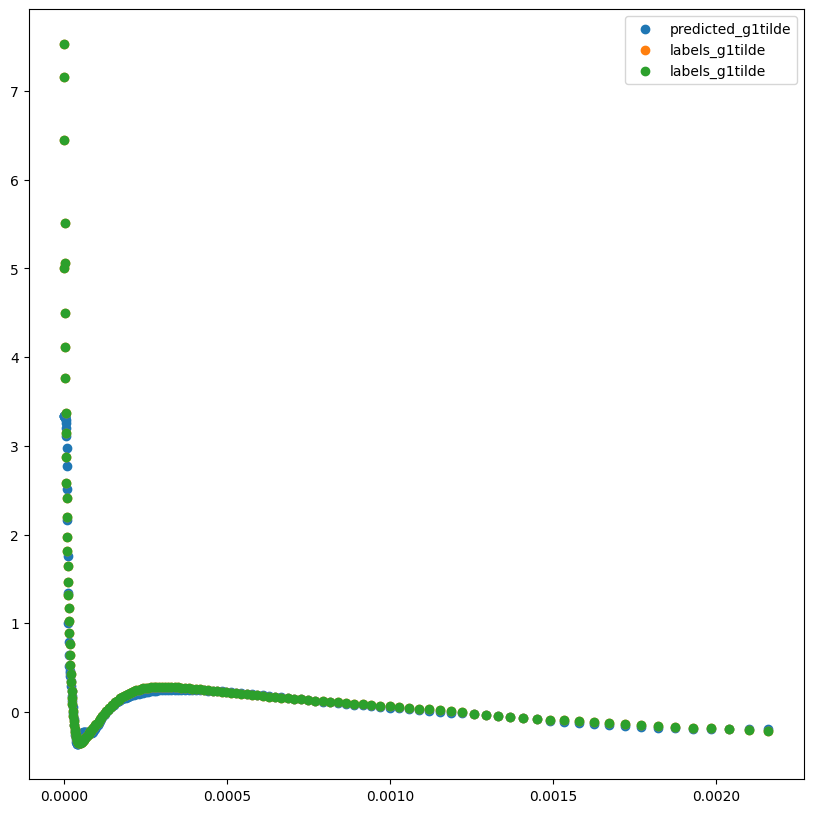

In [12]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g1tilde'],label='predicted_g1tilde')
axs.scatter(df_test['komegasst_C_2'],df_test['labels_scaled_g1tilde'],label='labels_g1tilde')
axs.scatter(df_test['komegasst_C_2'],df_test['DNS_g1tilde'],label='labels_g1tilde')

#axs.scatter(df_test['komegasst_C_2'],df_test['DNS_g1tilde'],label='DNS_g1tilde')

axs.legend()
#axs.set_ylim([-10,10])



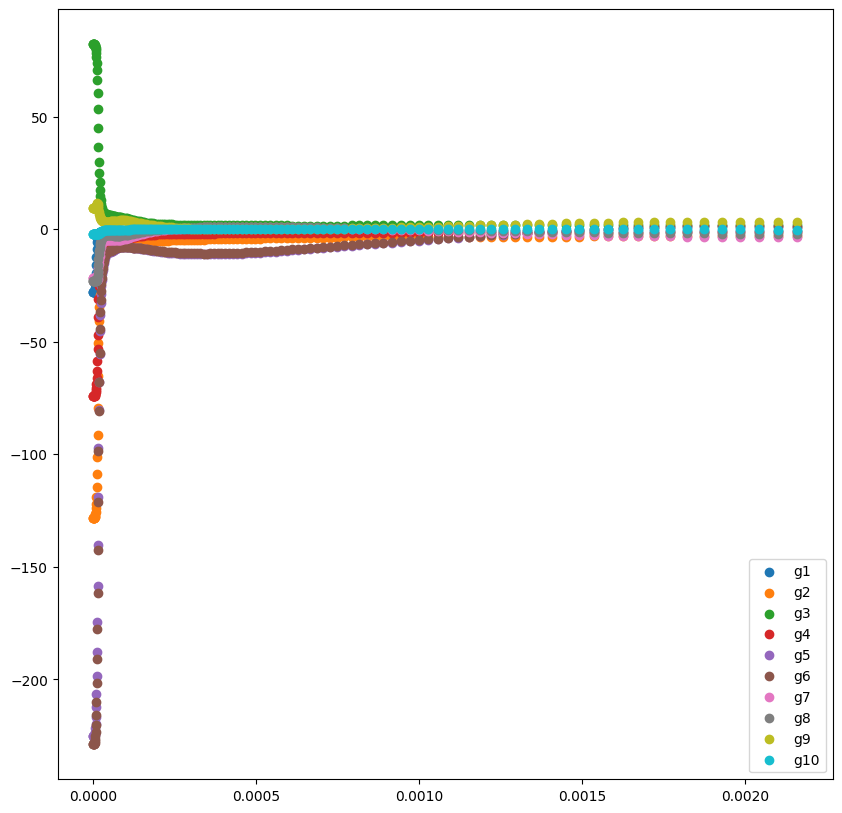

In [13]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g1'],label='g1')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g2'],label='g2')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g3'],label='g3')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g4'],label='g4')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g5'],label='g5')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g6'],label='g6')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g7'],label='g7')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g8'],label='g8')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g9'],label='g9')
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g10'],label='g10')
axs.legend()



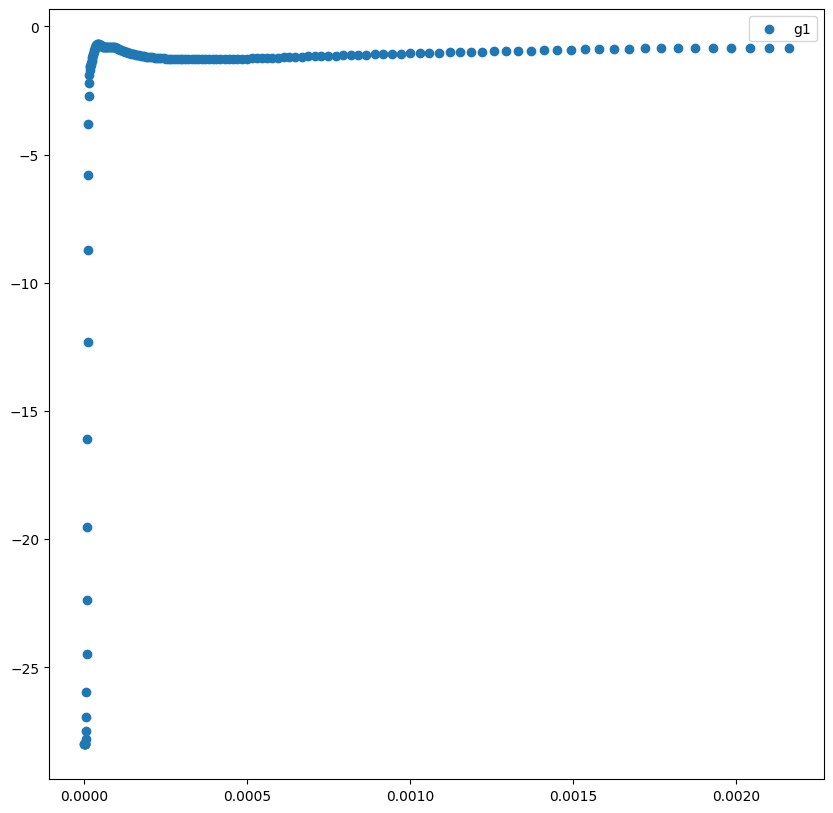

In [14]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
axs.scatter(df_test['komegasst_C_2'],df_test['pred_g1'],label='g1')

axs.legend()



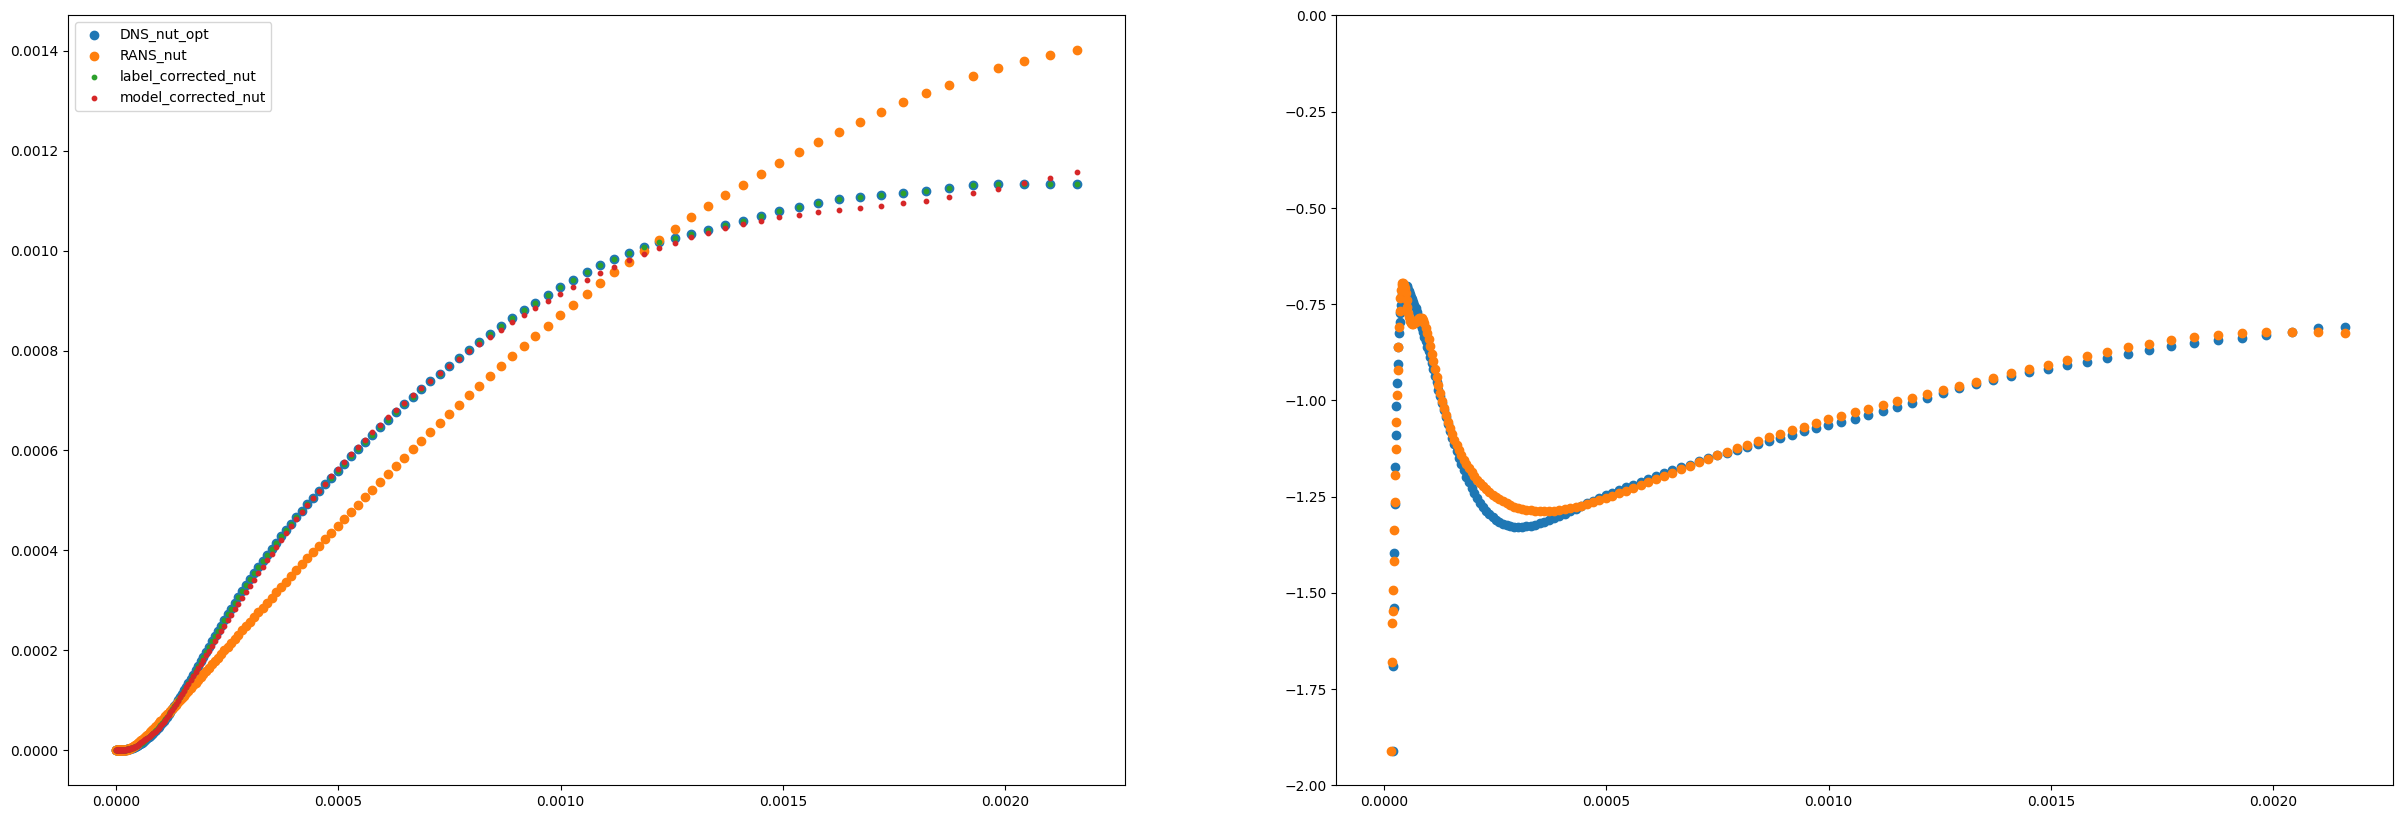

In [15]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(30,10))
axs[0].scatter(df_test['komegasst_C_2'],df_test['DNS_nut_nnls'],label='DNS_nut_opt')
axs[0].scatter(df_test['komegasst_C_2'],df_test['komegasst_nut'],label='RANS_nut')
axs[0].scatter(df_test['komegasst_C_2'],df_test['komegasst_nut']*np.exp(df_test['DNS_g1tilde']),s=10,label='label_corrected_nut')
axs[0].scatter(df_test['komegasst_C_2'],df_test['komegasst_nut']*np.exp(df_test['pred_g1tilde']),s=10,label='model_corrected_nut')

axs[1].scatter(df_test['komegasst_C_2'],-np.exp(df_test['DNS_g1tilde']),label='division')
axs[1].scatter(df_test['komegasst_C_2'],df_test['pred_g1'],label='g1')

#axs[1].scatter(df_test['komegasst_C_2'],df_test['DNS_nut_nnls']/df_test['komegasst_nut'],label='division')

axs[1].set_ylim([-2,0])
axs[0].legend()



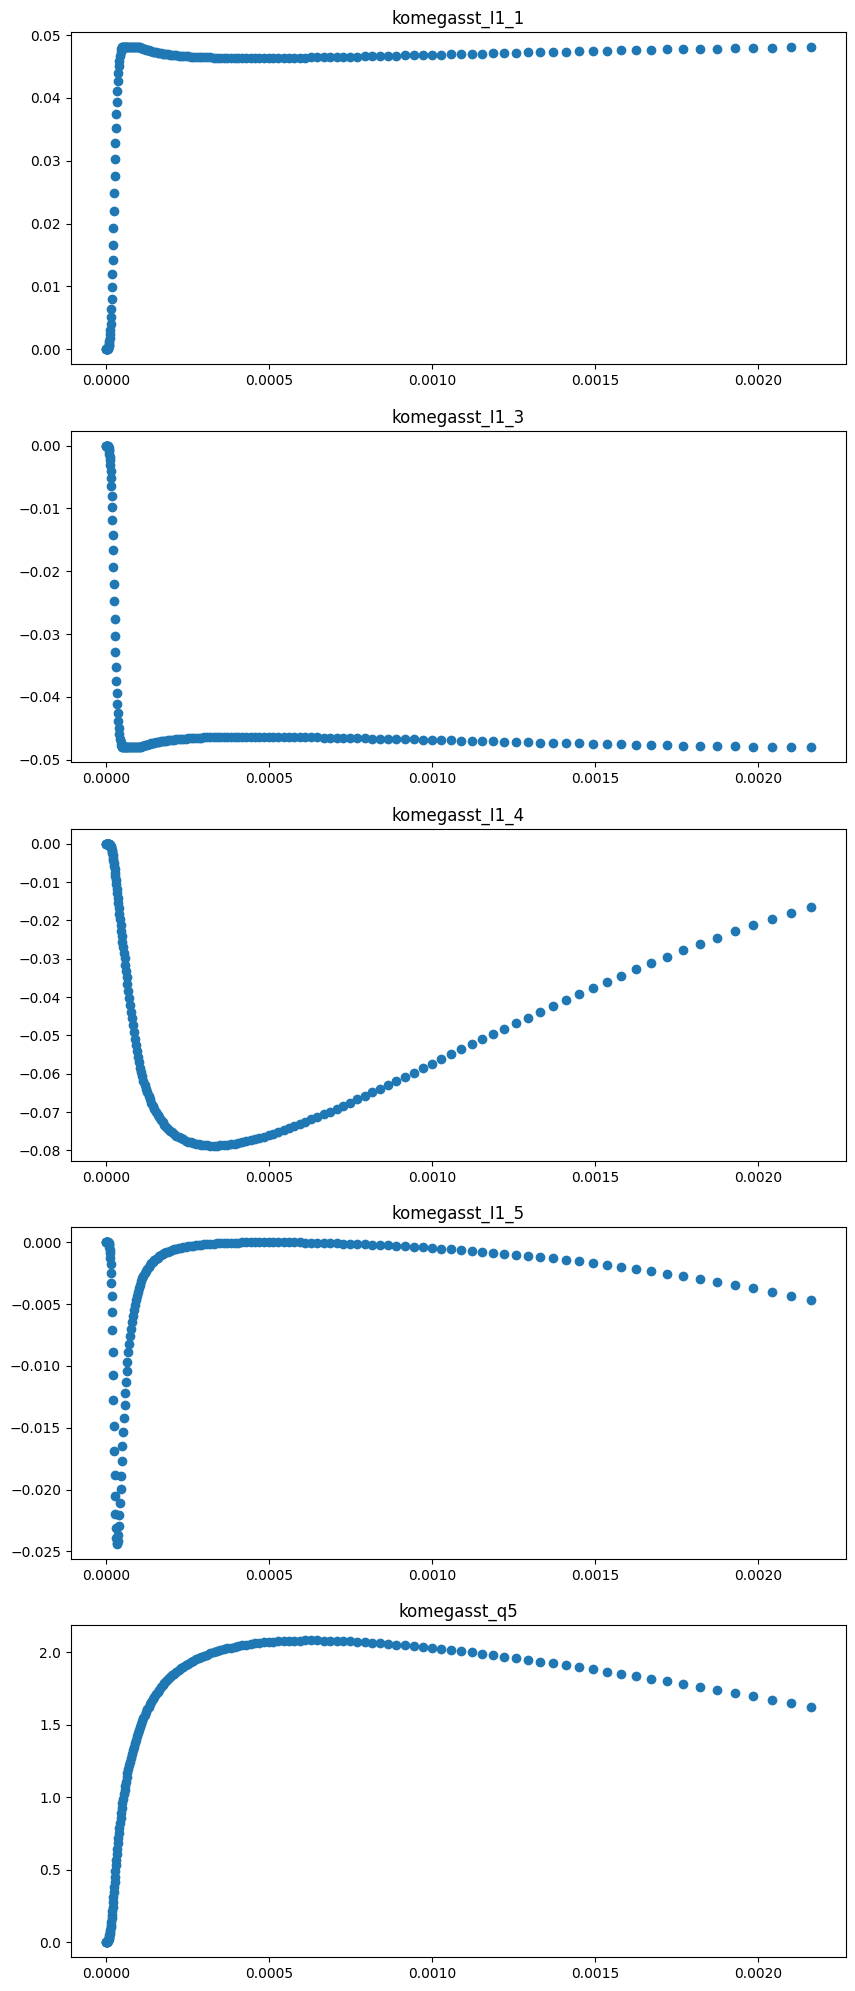

In [9]:
fig, axs = plt.subplots(nrows=len(model_params['input_features']),ncols=1,figsize=(10,len(model_params['input_features'])*5))
for i, ax in enumerate(axs):
    ax.scatter(df_test['komegasst_C_2'],df_test[model_params['input_features'][i]])
    ax.set_title(model_params['input_features'][i])


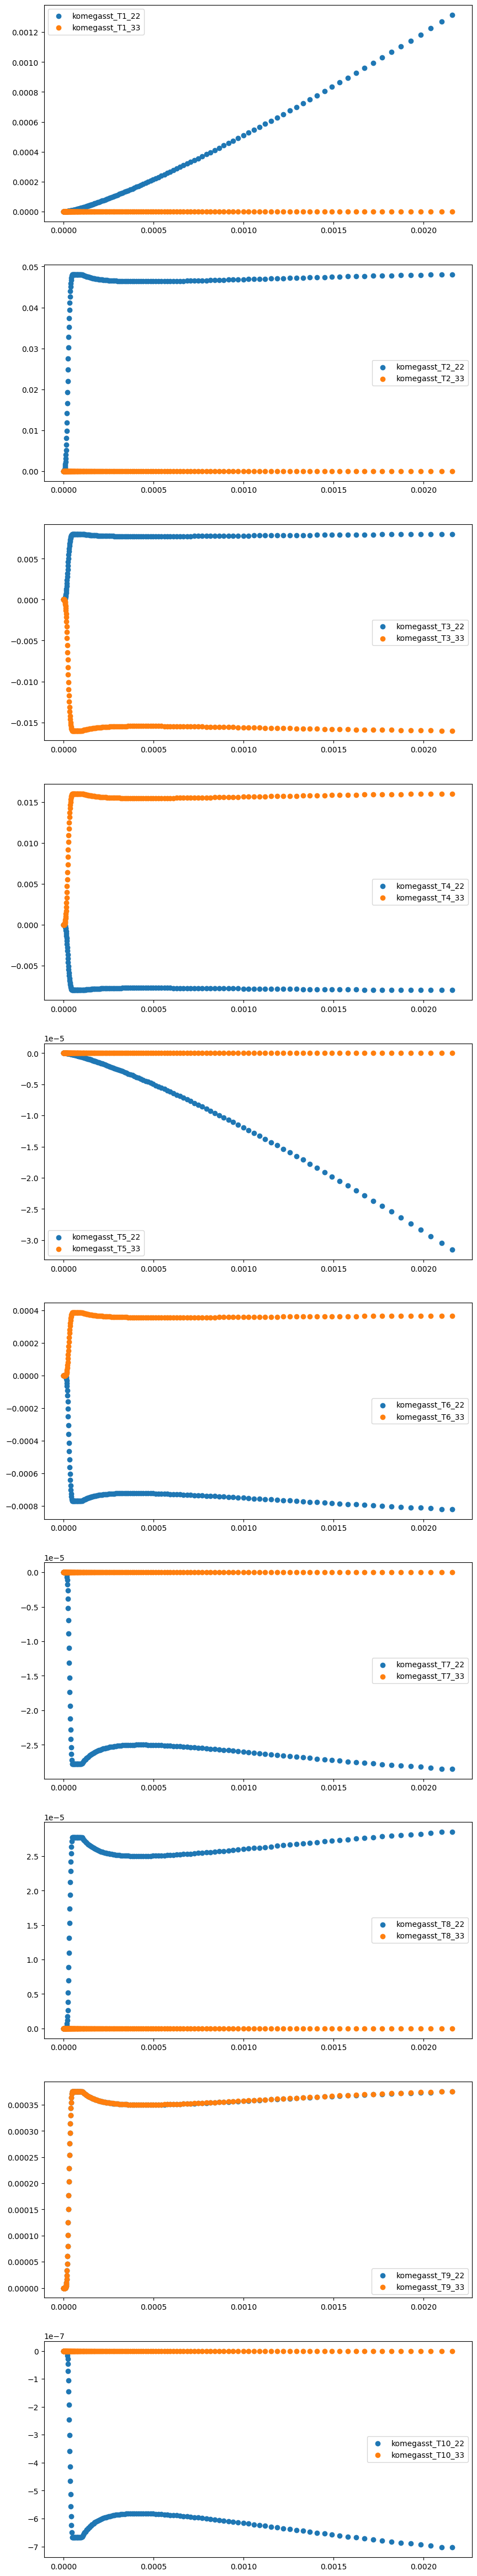

In [10]:
fig, axs = plt.subplots(nrows=10,ncols=1,figsize=(10,60))
for i,ax in enumerate(axs):
    ax.scatter(df_test['komegasst_C_2'],df_test[f'komegasst_T{i+1}_22'],label=f'komegasst_T{i+1}_22')
    ax.scatter(df_test['komegasst_C_2'],df_test[f'komegasst_T{i+1}_33'], label = f'komegasst_T{i+1}_33')
    ax.legend()
